In [94]:
#Packages

import os
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
from copy import deepcopy

from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals

In [95]:
# Function to call Praful's code, returning an Excel file with the cores identified

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

In [96]:
#Function to find the cores and print them. The function also rearrange the cores into Metzler matrices to check their positive unstability

def stoichio(data, SM, N_Y, N_RY):
    
    matrices = [] # List of cores that will be found

    SM = np.array(SM)
    
    for index, riga in data.iloc[1:].iterrows(): # Spanning among the rows of the Excel file (the rows are the autocatalytic cores)
        indices_N_Y = [i for i, valore in enumerate(riga[(2 + N_Y):(2 + 2*N_Y)]) if valore == 1]   # Save the species that belong to the core
        indices_N_RY = [i for i, valore in enumerate(riga[(2 + 2*N_Y):(2 + 2*N_Y + N_RY)]) if valore == 1]   # Save the reactions that belong to the core
        
        submatrix = SM[np.ix_(indices_N_Y, indices_N_RY)]

        matrices.append(submatrix) # Append all the cores together

    return matrices

In [97]:
def calculate_jacobian_and_eigenvalues(S1, S, kf, kr, N_Y, reverse, law):
    # Defining the species symbols
    species_sym = symbols(f'Y0:{N_Y}')
    
    # Convert S and S1 to integer types to avoid floating-point issues
    S = S.astype(int)
    S1 = S1.astype(int)

    # Constructing the symbolic expressions for the rates
    ratef_sym = np.array([kf[i] for i in range(len(kf))], dtype=object)  # Ensure symbolic compatibility
    rater_sym = np.array([kr[i] for i in range(len(kr))], dtype=object)

    # Now for each reaction, compute the rate based on the law (MAL or MM)
    if law == "MAL":
        for l in range(len(ratef_sym)):
            for s, p in zip(species_sym, S[:, l]):
                ratef_sym[l] *= s**p  # p is now an integer
            for s, p in zip(species_sym, S1[:, l]):
                rater_sym[l] *= s**p

    # Compute the net current (curr_forward - curr_backward)
    current_sym = ratef_sym - rater_sym
    
    # Create the Jacobian matrix as the derivative of (S1 - S) @ current_sym w.r.t. species
    jacobian = Matrix((S1 - S)) * Matrix(current_sym)
    jacobian = jacobian.jacobian(species_sym)
    print(jacobian)
    
    # Substitute all species concentrations to zero (since you want to evaluate at zero concentration)
    jacobian_zero = jacobian.subs({species_sym[i]: 0 for i in range(len(species_sym))})
    
    # Convert the symbolic Jacobian into a numeric matrix
    jacobian_numeric = np.array(jacobian_zero).astype(np.float64)

    # Compute the eigenvalues of the numeric Jacobian
    eigenvalues = eigvals(jacobian_numeric)
    
    # Return the maximum real part of the eigenvalues
    max_real_eigenvalue = max(eigenvalues.real)
    
    return max_real_eigenvalue, jacobian_numeric, eigenvalues


In [98]:
# Main function to check autocatalysis and run simulations  (THE OLDEST VERSION) THERMODYNAMIC CONSTRAINT

def invasion_thermo(N_X, N_RX, N_Y, N_RY, ttot, dt, Invasions, law, chemo):
    
    # Number of steps
    npas = int(ttot / dt)

    #max_lambda = []
    
    # Inizialization of compt
    compt = 0
    temps = 0
    TIME = 0
    r=0
    
    autocatalytics = []
    survival = []

    # Delete the previous output

    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]

    #Opening and setting up the Total Time file and the Stoiochiometric one
    resY = open("output/Time_%d.dat"%(r + 1), "w")
    resSp = open("output/Stoichio_%d.dat"%(r + 1), "w")

    resY.truncate(0)
    resSp.truncate(0)

    
    # Numbers of chemostats fixed at the beginning
    initials_chemo = N_X
    initials_react = N_RX

    S_X = np.zeros((N_X, N_RX))  # Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
    S1_X = np.zeros((N_X, N_RX)) # Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

    # S is the forward matrix (S+) and S1 is the reverse one (S-)
    
    
    X = [ 2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)] # Initialize original species

    kf = [random.uniform(0.95, 1.05) for _ in range(N_RX)] # Initialize constant values for the forward rates for the first N_RX reactions
    mu_0 = [random.uniform(-1, 1) for _ in range(N_X)] # For the thermodynamical feasibility of the reactions

    Ntot = sum(X) # Total concentrations that will be updated after every invasion
    Xtot = Ntot # Initial number of original species

    for i in range(N_RX):
        
        total_order_for = random.randint(0, 2)  # Total order for the forward
        total_order_bac = random.randint(0, 2)  # Total order for the backward
        stoichio_for = 0
        stoichio_bac = 0
    
        while(stoichio_for < total_order_for): # Costructing the stoichio forward matrix FOR ORIGINAL SPECIES randomly, up to a total order
    
            species = random.randint(0, N_X  - 1)
                
            S_X[species][i] += 1
            stoichio_for += 1
                
        # Setting the PRODUCTS depending on DILUTION, AMBIGUITY and AUTONOMY
    
        while(stoichio_bac < (total_order_bac)): # Costructing the stoichio backward matrix FOR ORIGINAL SPECIES randomly, up to a total order that changes depending on the assumption on autonomy
    
            species = random.randint(0, N_X - 1)
    
            S1_X[species][i] += 1
            stoichio_bac += 1


    # Overall stoichio matrix
    S_X_Tot = S1_X - S_X
    
    # Procedure to construct the input useful only for Praful's code
    new_stot_col = []

    for stot_col in S_X_Tot.T:
        new_stot_col.extend([stot_col, -stot_col])
    
    # Input for Praful's code in which all the reactions are present with their inverse
    Stot = np.column_stack(new_stot_col).astype(int)

    
    #Thermodynamical constraint to create the reverse rate constants
    mu_0_vector = np.array(mu_0).reshape(-1, 1)
    DeltaG0 = np.dot(S_X_Tot.T, mu_0_vector).flatten()

    kf_reversible = np.array(kf)
    kr_reversible = kf_reversible * np.exp(DeltaG0)  
    kr = kr_reversible

    
    '''max_real_eigenvalue, jacobian_zero, eigenvalues = calculate_jacobian_and_eigenvalues(S1[N_X:][:], S[N_X:][:], kf, kr, N_X, N_Y, reverse, law)
    max_lambda.append(max_real_eigenvalue)

    # Stampa degli autovalori
    print(f"Invasion {0}: Max real eigenvalue: {max_real_eigenvalue}")
    print(f"Jacobian at zero species concentrations:\n{jacobian_zero}")
    print(f"All eigenvalues: {eigenvalues}\n")'''
    

    auto(Stot, N_X) # Calling Praful's program on the ORIGINAL matrix
    data = pd.read_excel("output/AC_n%d.xlsx"%(N_X), header = None) 

    if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the ORIGINAL matrix from the excel output file

        print("INVADERS SHOW AUTOCATALYSIS \n \n")

        matrices= stoichio(data, Stot, N_X, N_RX) # This will print (not in the file) the eigenvalues of every core found!

        resSp.write('SHOWS AUTOCATALYSIS \n')

        autocatalytics.append(True)

    else:

        print("NO AUTOCATALYTIC BEHAVIOR \n \n")

        resSp.write("DOESN'T SHOW AUTOCATALYSIS \n")

        autocatalytics.append(False)


    
    res_invasion = open(f"output/time_{0}.dat", "w") # Opening the file for the evolution of the original species before any invasion
    #print(reverse)
    #print(reverse_indices)



    # ONLY IF CHEMO == FALSE I WILL LET THE FIRST N_RX ORIGINALS TO EVOLVE
    
    if chemo == False:
        for i in range(npas//100): # Two timescales to print not too much
                
            temps = (i * 100) * dt
            
            print(f"{round(temps,1)} {round(Ntot,3)} ", file=resY)
            
            for j in range(100):
                
                curr = np.zeros(N_RX)
    
                
                # If I have MAL, I update the currents each iteration
                if law == "MAL":
    
                    ratef = kf[:]
                    rater = deepcopy(kr)
                    
                    for l in range(N_RX):
                        
                        for s, p in zip(X, S_X[:,l]):  # Updating the currents for each reaction each time step
                            ratef[l] *= pow(s, p)
                        for s, p in zip(X, S1_X[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)   
                        
                        curr[l] = np.array(ratef[l]) - np.array(rater[l])
    
    
                # If I have MM, the forward rate will change, the backward will still be MAL
                if law == "MM":
    
                    ratef = np.ones(len(kf[:]))
                    rater = deepcopy(kr)
    
                    for l in range(N_RX):
                        
                        prod = 1
                        
                        for s, p in zip(X, S_X[:,l]):  # Updating the currents for each reaction each time step
                            prod *= pow(s, p)
                        ratef[l] = prod/(kf[l] + prod)
                       
                        for s, p in zip(X, S1_X[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)  
                            
                        curr[l] = np.array(ratef[l]) - np.array(rater[l])
                    
    
                # ODE 
                X += dt * np.dot((S1_X - S_X), np.array(curr))   # Solving a timestep ODE for the vector of originals
                X[X < 0] = 0 # Non-negativity condition
                
                Xtot = sum(X) # Updating the number of original species
                Ntot = Xtot # Updating the number of total species
    
                res_invasion.write(f"{round(TIME+temps, 1)}") # Time step on the file
                
                for x in X:
                    res_invasion.write(f" {round(x, 3)}") # Concentration of the species on the file
                res_invasion.write("\n")
    
        if Xtot >= 0.2: # Threshold for survival
                
            resSp.write("\n")
            resSp.write('ORIGINALS GREW')
            resSp.write("\n")
                
        
            survival.append(True)
        
        else: 
            resSp.write("\n")
            resSp.write("ORIGINALS DIDN'T GROW")
            resSp.write("\n")
    
            survival.append(False)
    
    
        res_invasion.close()

    # OTHERWISE I WILL PRINT THEM AS CONSTANTS
    
    else:
        
        for i in range(npas//100): # Two timescales to print not too much
                
            temps = (i * 100) * dt
            
            res_invasion.write(f"{round(TIME+temps, 1)}")
            for x in X:
                res_invasion.write(f" {round(x, 3)}")
            res_invasion.write("\n")

            print(f"{round(temps + TIME ,1)} {round(Ntot,3)} ", file=resY)
    

        
    TIME += ttot

    

    # SET OF INVASIONS




    counter=True
    for r in range(Invasions):
    
        S_Y = np.zeros((N_X + N_Y, N_RY)) # Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
        S1_Y = np.zeros((N_X + N_Y, N_RY)) # Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

        # S is the forward matrix (S+) and S1 is the reverse one (S-)

        res_invasion = open(f"output/time_{r+1}.dat", "w") # File for the invasions' printings
        
        

        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)] # Initialize values for the new invaders' species
        Ytot = Y

        if counter:
            new_kf = [random.uniform(0.95, 1.05) for _ in range(N_RY)] # Initialize constant values for the forward rates
            new_mu0 = [random.uniform(-1, 1) for _ in range(N_Y)] # For the thermodynamical feasibility of the reactions

            kf.extend(new_kf) # Adding constants and mu_0 to the ones before
            mu_0.extend(new_mu0)
    
        for i in range(N_RY):
                
            total_order_for = random.randint(0, 2)  # Total order for the forward
            total_order_bac = random.randint(0, 2)  # Total order for the backward
            stoichio_for = 0
            stoichio_bac = 0

            # Setting the necessary reactants without ambiguity
            
            species1 = random.randint(0, N_Y - 1) # There must be at least one Y as reactant
            S_Y[N_X + species1][i] += 1
            

            # Setting the necessary products without ambiguity
                
            species2 = random.randint(0, N_Y - 1)
                
            while species2 == species1:
                species2 = random.randint(0, N_Y - 1) # Non-ambiguity condition
            S1_Y[N_X + species2][i] += 1    # There must be at least one Y as product
                


        
            while(stoichio_for < total_order_for - 1): # Costructing the stoichio forward matrix randomly, up to a total order

                species = random.randint(0, N_X + N_Y - 1)

                if S1_Y[species][i] == 0:  # Non ambiguity
                    S_Y[species][i] += 1
                    stoichio_for += 1



    
            while(stoichio_bac < (total_order_bac - 1)): # Costructing the stoichio backward matrix randomly, up to a total order that changes depending on the assumption on autonomy
    
                species = random.randint(0, N_Y - 1)  # NO X's AS PRODUCTS

                if S_Y[N_X + species][i] == 0:  # Non ambiguity
                    S1_Y[N_X + species][i] += 1
                    stoichio_bac += 1

        # MATRIX OF THE INVADERS    
        S_Y_Tot = S1_Y - S_Y


        #CONSTRUCTION OF THE WHOLE MATRIX OF ORIGINAL AND INVADERS
        zeros_below_S_X = np.zeros((N_Y, N_RX))

        upper_block = np.hstack((S_X, S_Y[:N_X]))
        
        lower_block = np.hstack((zeros_below_S_X, S_Y[N_X:])) 
        
        S_XandY_forward = np.vstack((upper_block, lower_block))

        upper_block = np.hstack((S1_X, S1_Y[:N_X]))
        
        lower_block = np.hstack((zeros_below_S_X, S1_Y[N_X:])) 

        S_XandY_backward = np.vstack((upper_block, lower_block))

        #NON-INVERTED WHOLE MATRIX
        S_XandY = S_XandY_backward - S_XandY_forward
                    
    
        # AUTOCATALYSIS CHECKING
        # Preparing the input for Praful's code splitting the reactions in backward and forward

        new_stot_col = []
        
        for stot_col in S_XandY.T:
            new_stot_col.extend([stot_col, -stot_col])
        
        #INVERTED WHOLE MATRIX
        S_XandY_Tot = np.column_stack(new_stot_col).astype(int)
    
        
        #print(reverse)
        #print(reverse_indices)
    
        
        #Thermodynamical constraint
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S_XandY.T, mu_0_vector).flatten()
    
        kf_reversible = np.array(kf)
        kr_reversible = kf_reversible * np.exp(DeltaG0)  
        kr = kr_reversible


        ''' max_real_eigenvalue, jacobian_zero, eigenvalues = calculate_jacobian_and_eigenvalues(S1[N_X:][:], S[N_X:][:], kf, kr, N_X, N_Y, reverse, law)
        max_lambda.append(max_real_eigenvalue)

        # Stampa degli autovalori
        print(f"Realization {r + 1}: Max real eigenvalue: {max_real_eigenvalue}")
        print(f"Jacobian at zero species concentrations:\n{jacobian_zero}")
        print(f"All eigenvalues: {eigenvalues}\n") '''
        
        auto(S_XandY_Tot, N_X + N_Y) # Calling Praful's program on the new WHOLE matrix
        data = pd.read_excel("output/AC_n%d.xlsx"%(N_X + N_Y), header = None) 
    
        if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the WHOLE matrix from the excel output file
    
            print("INVADERS SHOW AUTOCATALYSIS \n \n")

            matrices = stoichio(data, S_XandY_Tot, N_X + N_Y, N_RX + N_RY) # This will print (not in the file) the eigenvalues of every core found!

            resSp.write('SHOWS AUTOCATALYSIS \n')
    
            autocatalytics.append(True)
    
        else:
    
            print("NO AUTOCATALYTIC BEHAVIOR \n \n")

            resSp.write("DOESN'T SHOW AUTOCATALYSIS \n")
    
            autocatalytics.append(False)
            
        
        for i in range(npas//100): # Two timescales to print not too much
            
            temps = (i * 100) * dt
            
            print(f"{round(temps + TIME ,1)} {round(Ntot,3)} ", file=resY)
            
            for j in range(100):
                
                curr = np.zeros(N_RX + N_RY)

                
                # If I have MAL, I update the currents each iteration
                if law == "MAL":

                    ratef = kf[:]
                    rater = deepcopy(kr)
                    
                    for l in range(N_RX + N_RY):
                        
                        for s, p in zip(np.concatenate((X,Y)), S_XandY_forward[:,l]):  # Updating the currents for each reaction each time step
                            ratef[l] *= pow(s, p)
                        for s, p in zip(np.concatenate((X,Y)), S_XandY_backward[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)   
                       
                        curr[l] = np.array(ratef[l]) - np.array(rater[l])
                            

                # If I have MM, the forward rate will change, the backward will still be MAL
                if law == "MM":

                    ratef = np.ones(len(kf[:]))
                    rater = deepcopy(kr)

                    for l in range(N_RY):
                        
                        prod = 1
                        
                        for s, p in zip(np.concatenate((X,Y)), S_XandY_forward[:,l]):  # Updating the currents for each reaction each time step
                            prod *= pow(s, p)
                        ratef[l] = prod/(kf[l] + prod)
                       
                        for s, p in zip(np.concatenate((X,Y)), S_XandY_backward[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)  

                        curr[l] = np.array(ratef[l]) - np.array(rater[l])               

                # ODE 
                Y += dt * np.dot((S_XandY)[N_X:][:], np.array(curr))   # Solving a timestep ODE for the vector of invaders
                Y[Y < 0] = 0 # Non-negativity condition

                if chemo == False:
                    X += dt * np.dot((S_XandY)[:N_X][:], np.array(curr))   # Solving a timestep ODE for the vector of ORIGINALS if non chemostated
                    X[X < 0] = 0 # Non-negativity condition
                else:
                    X[initials_chemo:] += dt * np.dot((S_XandY)[initials_chemo:N_X][:], np.array(curr))   # Solving a timestep ODE for the vector of ORIGINALS
                    #A PART FROM THE FIRST N_RX WHICH WILL REMAIN CHEMOSTATED
                    X = np.array(X)
                    X[X < 0] = 0 # Non-negativity condition

                
                Xtot = sum(X) # Update the originals species
                Ytot = sum(Y) # Update the invaders species
                Ntot = Xtot + Ytot

            res_invasion.write(f"{round(TIME+temps, 1)}")
            for x in np.concatenate((X,Y)):
                res_invasion.write(f" {round(x, 3)}")
            res_invasion.write("\n")
        res_invasion.close()


        # HISTOGRAM OF THE CURRENTS AT STEADY STATE, FOR EACH INVASION
        x_labels = [f'current_{val}' for val in range(len(curr))]

        log_curr = np.sign(curr) * np.log(np.abs(curr))
        
        plt.figure(figsize=(10, 6))
        plt.bar(x_labels, log_curr, color='skyblue', edgecolor='black')
        
        plt.xlabel('Currents (Log scale)')
        plt.ylabel('Values')
        plt.title('Histogram of Log-Currents')
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.show()
    
                
        resSp.write('\n')
        np.savetxt(resSp, S_Y_Tot, fmt='%d', delimiter=' ', header='', comments='')     # Printing the INVADERS survival matrix in "Stoichio_matrix_Y"
        resSp.write('\n \n')
        np.savetxt(resSp, S_XandY, fmt='%d', delimiter=' ', header='', comments='') # Printing the WHOLE survival matrix in "Stoichio_matrix_Y"
    
        TIME += ttot

        
        if Ytot >= 0.2: # Threshold for survival
            compt += 1
            
            resSp.write("\n")
            resSp.write('INVADERS GREW')
            resSp.write("\n")

            # INVADERS BECOME ORIGINAL SPECIES IF THEY SURVIVED
            N_X += N_Y
            N_RX += N_RY
    
            S1_X = S_XandY_backward
            S_X = S_XandY_forward
    
            X = np.concatenate((X,Y))
            Xtot += Ytot
            counter = True
            survival.append(True)
    
        else: 
            resSp.write("\n")
            resSp.write("INVADERS DIDN'T GROW")
            resSp.write("\n")
    
            survival.append(False)
            counter = False


        '''# Printing all the cores in the stoichio file, if there was autocatalysis, for such a realization
        if  len(data.iloc[:][0]) > 1:
            
            resSp.write('\n\n\n CORES:\n')
            for i in range(len(matrices)):
                np.savetxt(resSp, matrices[i], fmt='%d', delimiter=' ', header='', comments='')
                resSp.write('\n')'''

    
     # Saving and closing the open files
    
    print(f"{compt}/{Invasions} Realizations led to successful invasion")
    resSp.close()
    resY.close() 

    return autocatalytics, survival

In [99]:
#Parameters definition

ttot = float(100.0) # Total time for the each invasion
dt = 1.0E-3 # Timestep

npas = int(ttot//dt)

Invasions = 5 # Number of invasions

N_X = 3 # Number of species in the original dynamic system
N_RX = 2  # Number of reactions in the original systems (NOT NEEDED IF X's ARE CONSTANTS)

N_Y = 3  # Number of invaders (must be higher than 3, otherwise I can end up with ambiguity)
N_RY = 3  # Number of reactions for the invaders

#Species:  3 # Reactions:  4
#Species:  3 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
NO AUTOCATALYTIC BEHAVIOR 
 

#Species:  6 # Reactions:  10
#Species:  6 # Reactions:  10
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R5', 'R8', 'R9']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R5: C_4 ->C_5+C_6
			 R8: C_5 ->C_6
			 R9: C_6 ->C_4
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 1
Consumed Time: 0.00 secs.
Saved in output/AC_n6.xlsx
INVADERS SHOW AUTOCATALYSIS 
 



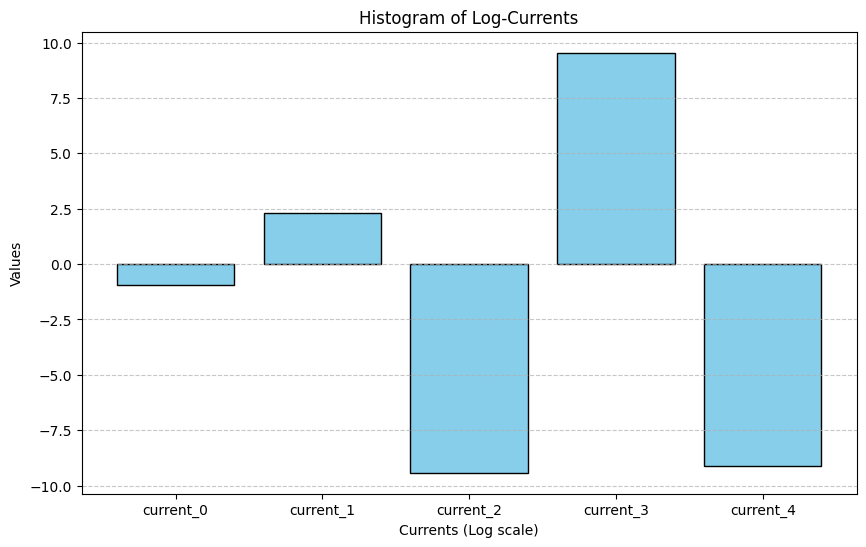

#Species:  9 # Reactions:  16
#Species:  9 # Reactions:  16
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R5', 'R8', 'R9']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R5: C_4 ->C_5+C_6
			 R8: C_5 ->C_6
			 R9: C_6 ->C_4
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_7', 'C_8', 'C_9']
	 Reactions in AC:  ['R11', 'R13', 'R16']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R11: C_7 ->C_8
			 R13: C_8 ->C_7+C_9
			 R16: C_9 ->C_7
	 - CPU Time: 0.01 secs


# Autocatalytic Cycles: 2
Consumed Time: 0.01 secs.
Saved in output/AC_n9.xlsx
INVADERS SHOW AUTOCATALYSIS 
 



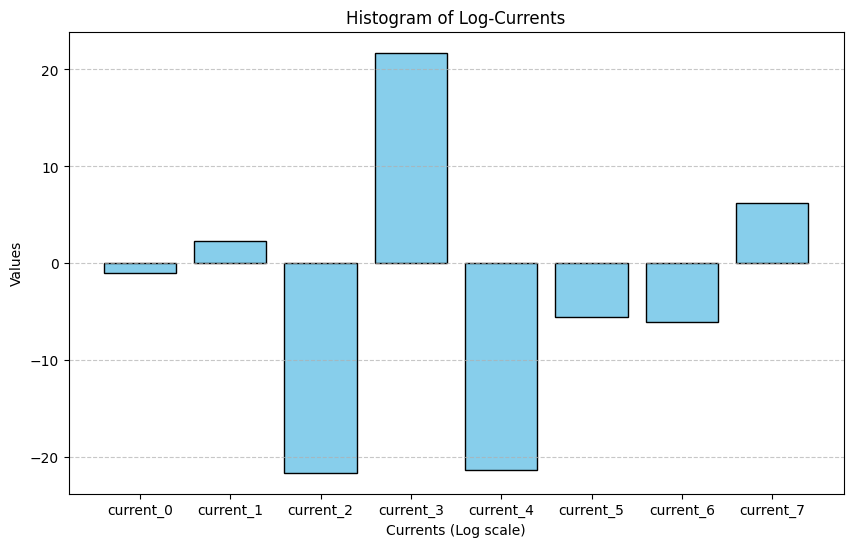

#Species:  12 # Reactions:  22
#Species:  12 # Reactions:  22
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C_11']
	 Extra M in AC:  []
	 Species in AC:  ['C_10', 'C_12']
	 Reactions in AC:  ['R17', 'R21']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R17: C_10 ->C_11+C_12
			 R21: C_12 ->2C_10
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R5', 'R8', 'R9']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R5: C_4 ->C_5+C_6
			 R8: C_5 ->C_6
			 R9: C_6 ->C_4
	 - CPU Time: 0.01 secs
**** Sol 3: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_7', 'C_8', 'C_9']
	 Reactions i

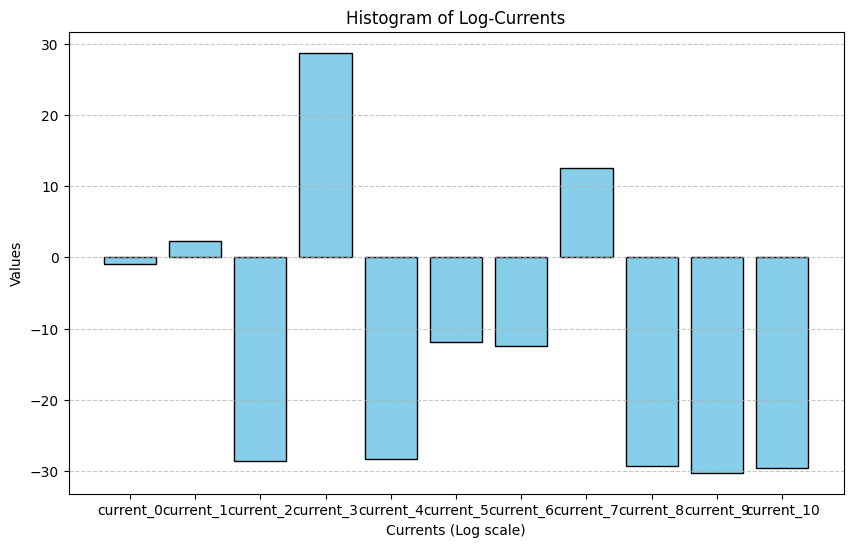

#Species:  15 # Reactions:  28
#Species:  15 # Reactions:  28
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C_11']
	 Extra M in AC:  []
	 Species in AC:  ['C_10', 'C_12']
	 Reactions in AC:  ['R17', 'R21']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R17: C_10 ->C_11+C_12
			 R21: C_12 ->2C_10
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R5', 'R8', 'R9']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R5: C_4 ->C_5+C_6
			 R8: C_5 ->C_6
			 R9: C_6 ->C_4
	 - CPU Time: 0.00 secs
**** Sol 3: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_7', 'C_8', 'C_9']
	 Reactions i

/tmp/ipykernel_4034/3716331905.py:458: RuntimeWarning: divide by zero encountered in log
  log_curr = np.sign(curr) * np.log(np.abs(curr))
/tmp/ipykernel_4034/3716331905.py:458: RuntimeWarning: invalid value encountered in multiply
  log_curr = np.sign(curr) * np.log(np.abs(curr))


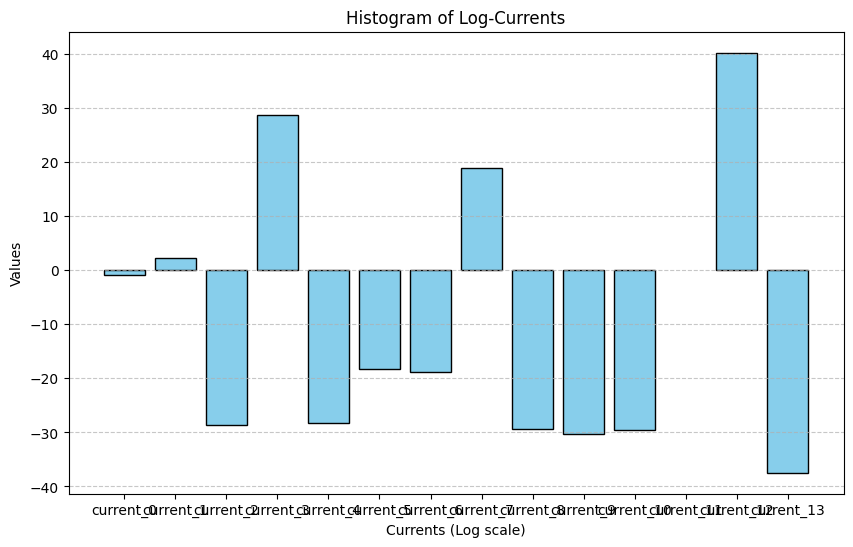

#Species:  15 # Reactions:  28
#Species:  15 # Reactions:  28
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C_11']
	 Extra M in AC:  []
	 Species in AC:  ['C_10', 'C_12']
	 Reactions in AC:  ['R17', 'R21']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R17: C_10 ->C_11+C_12
			 R21: C_12 ->2C_10
	 - CPU Time: 0.01 secs
**** Sol 2: 2 reactions
	 #Species:  2 #FoodSet:  0 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set []
	 Waste Set ['C_13']
	 Extra M in AC:  []
	 Species in AC:  ['C_14', 'C_15']
	 Reactions in AC:  ['R23', 'R25']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R23: C_14 ->C_13+C_15
			 R25: C_15 ->2C_14
	 - CPU Time: 0.00 secs
**** Sol 3: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set []
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5', 'C_6']
	 Reactions in AC:  ['R5', 'R8'

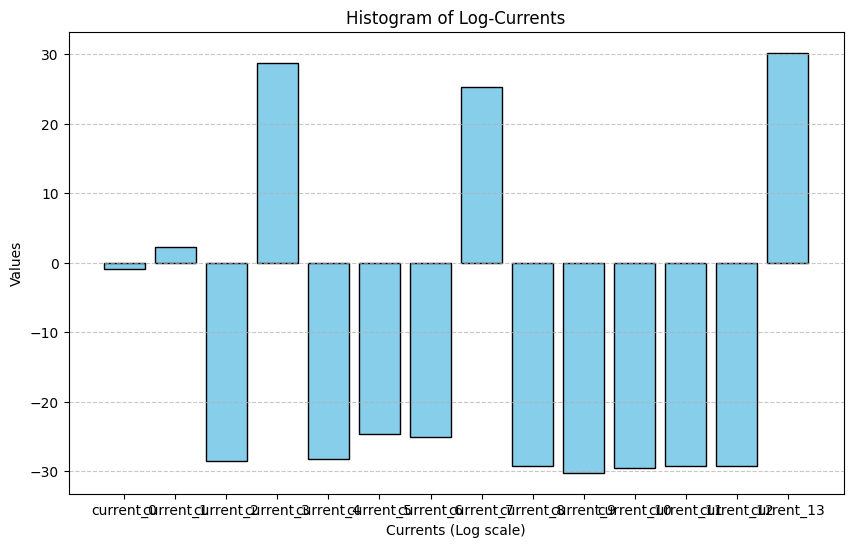

4/5 Realizations led to successful invasion


In [100]:
# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior

autocatalytics,survival = invasion_thermo(N_X, N_RX, N_Y, N_RY, ttot, dt, Invasions, law = "MAL", chemo = True)

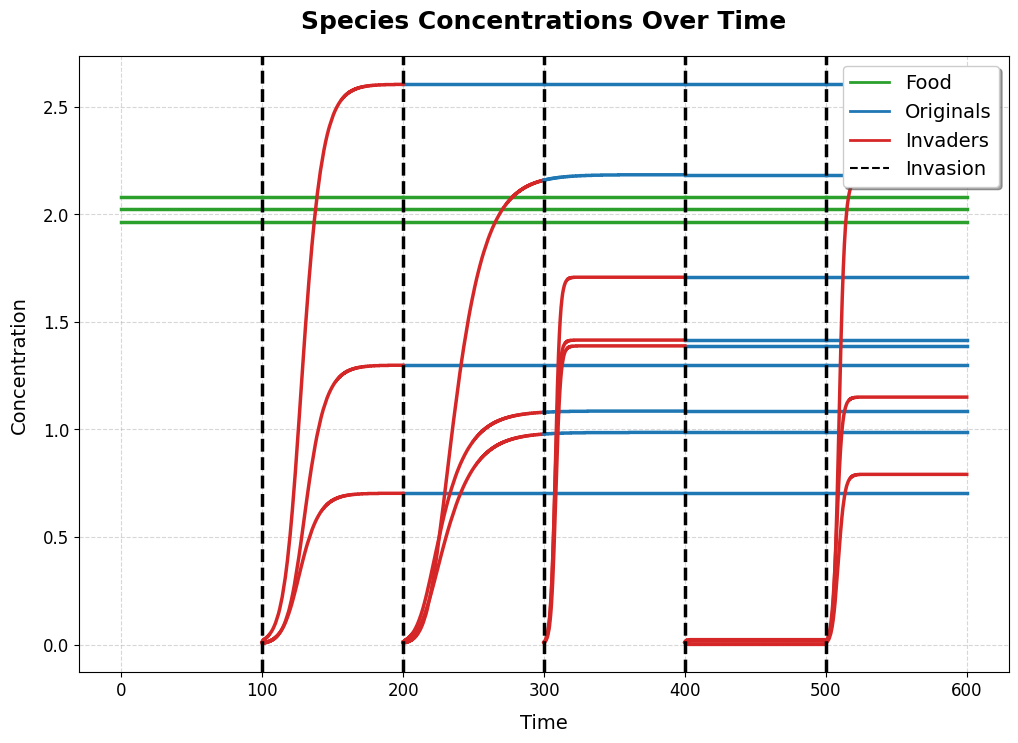

In [103]:
# Set the folder path
folder_path = "output"
file_list = glob.glob(os.path.join(folder_path, "time_*"))

# Create values for the invasions on the x-axis
ttot_values = np.linspace(ttot, ttot * Invasions, Invasions) 

# Figure size and grid
plt.figure(figsize=(12, 8))
plt.grid(True, linestyle='--', alpha=0.5)

# Loop through the files to plot the species
for file in file_list:
    data = pd.read_csv(file, delimiter='\s+', header=None)
    time = data.iloc[:, 0]
    species_data = data.iloc[:, 1:]
    
    # Loop through each species column
    for species_idx in range(species_data.shape[1]):
        if species_idx < N_X:  # First N_X columns in green
            color = '#2ca02c'
        elif species_idx >= species_data.shape[1] - N_Y:  # Last N_Y columns in red
            color = '#d62728'
        else:  # Remaining columns in blue
            color = '#1f77b4'
        
        # Plot each species concentration over time
        plt.plot(time, species_data.iloc[:, species_idx], color=color, linewidth=2.5, alpha=1)

# Vertical lines for invasions
for ttots in ttot_values:
    plt.axvline(x=ttots, color='black', linestyle='--', linewidth=2.5, alpha=1)

# Title and axis labels
plt.title('Species Concentrations Over Time', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14, labelpad=10)
plt.ylabel('Concentration', fontsize=14, labelpad=10)

# Customize axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend for species categories and invasion
legend_elements = [
    Line2D([0], [0], color='#2ca02c', lw=2, label='Food'),
    Line2D([0], [0], color='#1f77b4', lw=2, label='Originals'),
    Line2D([0], [0], color='#d62728', lw=2, label='Invaders'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='Invasion')
]
plt.legend(handles=legend_elements, fontsize=14, frameon=True, shadow=True, loc='upper right')

# Save and display the plot
plt.savefig("Successive_species_concentrations_2.pdf", dpi=300, bbox_inches='tight')
plt.show()



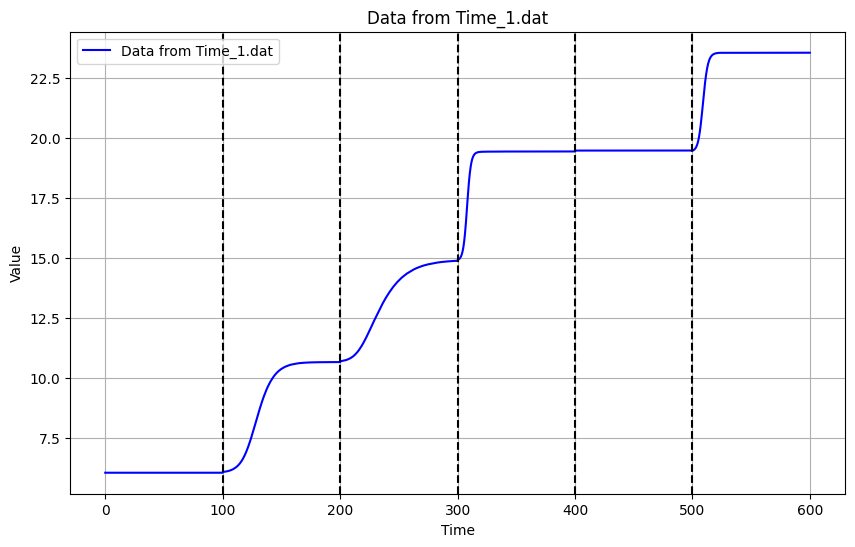

In [102]:

file_path = 'output/Time_1.dat'

data = pd.read_csv(file_path, delimiter='\s+', header=None)

time = data.iloc[:, 0]
values = data.iloc[:, 1]

ttot_values = np.linspace(ttot, ttot*(Invasions), Invasions) 

plt.figure(figsize=(10, 6))
plt.plot(time, values, label='Data from Time_1.dat', color='blue')

for ttots in ttot_values:
    plt.axvline(x=ttots, color='black', linestyle='--')

plt.xlabel('Time') 
plt.ylabel('Value')  
plt.title('Data from Time_1.dat') 
plt.legend()  
plt.grid(True)  
plt.show()  


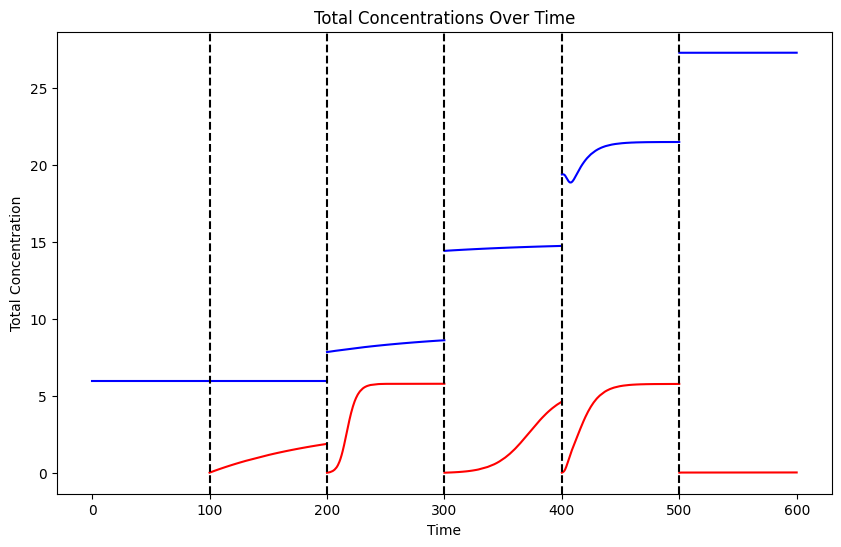

In [85]:

folder_path = "output"
file_list = glob.glob(os.path.join(folder_path, "time_*"))

plt.figure(figsize=(10, 6))  
ttot_values = np.linspace(ttot, ttot*(Invasions), Invasions) 
for file in file_list:
    data = pd.read_csv(file, delimiter='\s+', header=None)
    
    time = data.iloc[:, 0]
    species_data = data.iloc[:, 1:]
    
    total_blue = None
    total_red = None

    if os.path.basename(file) == "time_0.dat":
        total_blue = species_data.sum(axis=1)
    else:
        total_red = species_data.iloc[:, -N_Y:].sum(axis=1)
        total_blue = species_data.iloc[:, :-N_Y].sum(axis=1)
    
    plt.plot(time, total_blue, label=f'Total Blue from {os.path.basename(file)}', color='blue')
    if total_red is not None:
        plt.plot(time, total_red, label=f'Total Red from {os.path.basename(file)}', color='red')

for ttots in ttot_values:
    plt.axvline(x=ttots, color='black', linestyle='--')

plt.xlabel('Time')  
plt.ylabel('Total Concentration')  
plt.title('Total Concentrations Over Time')
#plt.legend() 
plt.show() 
